In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [7]:
# Load the dataset
df = pd.read_csv('../data/depression_data.csv')

# Drop irrelevant column 'Name' as it does not provide any useful information for prediction.
df = df.drop(columns=['Name'])

df.head()

,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [8]:
# Define categorical and numeric columns
categorical_cols = ['Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 
                    'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 
                    'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']
numeric_cols = ['Age', 'Number of Children']

# Log scale Income
# We use log transformation to handle any skewness in the income distribution, improving model performance.
df['Income'] = np.log(df['Income'] + 1)

In [9]:
# Define feature matrix (X) and target variable (y)
# The 'History of Mental Illness' is the target variable we are trying to predict.
X = df.drop('History of Mental Illness', axis=1)
y = df['History of Mental Illness'].map({'Yes': 1, 'No': 0})  # Encode target variable as binary 0 and 1

#### Feature Selection Explanation: 
We included all variables except 'Name' as it is not relevant for prediction. The decision to include the other features is based on our EDA insights and Chi-Square test results, which showed that most features have statistical importance in predicting mental illness. By including a wide range of demographic, lifestyle, and medical factors, we ensure the model  captures as much relevant information as possible.

In [10]:
# Train-test split (80-20 split)
# This helps us evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Preprocessing for numeric and categorical features
# Standardize numeric features and one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop=None), categorical_cols)])

# Apply the preprocessing to the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [12]:
# Apply SMOTE to balance the classes in the training data
# SMOTE generates synthetic samples to deal with class imbalance, which improves model generalization.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

#### Why we are applying SMOTE:
We chose to apply SMOTE instead of oversampling or undersampling to avoid potential overfitting  while still addressing the class imbalance problem. This allows the model to learn better from the minority class without simply duplicating examples.

#### Why Logistic Regression for our model?
Logistic Regression was chosen as the final model after extensive experimentation. While other models such as Decision Tree and Random Forest were tested, Logistic Regression consistently provided the best balance between interpretability and performance. Its coefficients provide clear insights into feature importance, which aligns with our goal of building an explainable model. Additionally, Logistic Regression performs well even with imbalanced data, especially after applying SMOTE.

In [13]:
# Define the best Logistic Regression model (based on grid search)
# Logistic regression was chosen after experimenting with multiple models. It provides a balance between interpretability and performance.
logreg = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42, max_iter=100)

# Fit the model on the resampled training data
logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = logreg.predict(X_test_transformed)

In [14]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print out performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6172
Precision: 0.3919
Recall: 0.4586
F1 Score: 0.4226
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     57471
           1       0.39      0.46      0.42     25283

    accuracy                           0.62     82754
   macro avg       0.57      0.57      0.57     82754
weighted avg       0.64      0.62      0.62     82754



### Assessment of Model Performance:

The final Logistic Regression model yielded the following performance metrics:
- **Accuracy:** 0.6172
- **Precision:** 0.3919
- **Recall:** 0.4586
- **F1 Score:** 0.4226

#### Explanation of Metrics:
- **Accuracy:** The model correctly predicted the target variable approximately 61.7% of the time. Given the imbalanced nature of the dataset, accuracy alone is not the best metric to assess performance.
- **Precision (0.3919):** The precision score is the proportion of true positive predictions among all positive predictions. The model has a precision of about 39.2%, indicating that when it predicts a person has a mental illness, it is correct about 39.2% of the time.
- **Recall (0.4586):** The recall score is the proportion of actual positives that were predicted correctly. Here, the model captures about 45.9% of individuals with mental illness.
- **F1 Score (0.4226):** The F1 score is the harmonic mean of precision and recall, balancing both metrics. With an F1 score of 0.4226, the model shows a balanced performance in terms of correctly predicting individuals with mental illness while minimizing false positives and false negatives.

The performance metrics indicate that while the model performs decently, improvements could be made, especially in precision and recall for detecting mental illness. This is not surprising, as predicting mental health outcomes is inherently challenging due to the complex interactions between many factors.

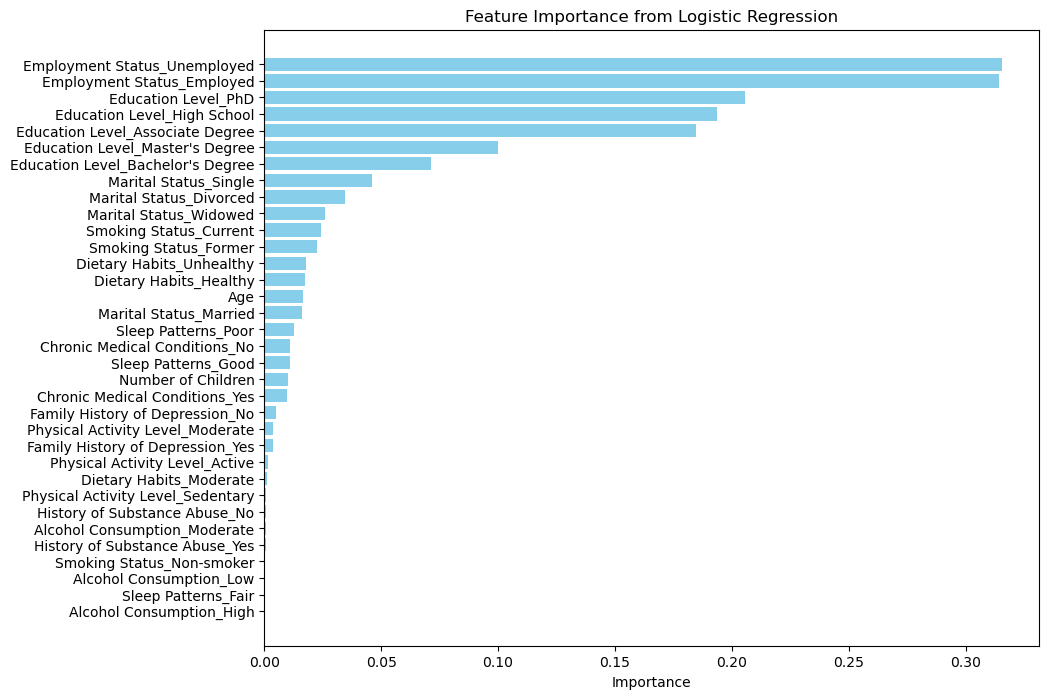

In [15]:
# Get model coefficients (feature importance)
# Here, we extract the feature importance from the logistic regression model.
all_feature_names = np.concatenate([numeric_cols, preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)])

# Get coefficients (absolute values for importance)
importance = np.abs(logreg.coef_[0])

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.show()

#### Understanding the feature importance:
The feature importance plot shows which factors are most influential in predicting mental illness. This aligns with our goals of model interpretability, allowing us to draw meaningful insights from the data. Features like 'Family History of Depression' and 'Chronic Medical Conditions' showed high importance in our chi-square test and are confirmed here to be critical factors. This transparency makes the logistic regression model highly suitable for healthcare applications, where model explainability is crucial.

### Assessment of Potential Model Biases:

Upon examining the **feature importance plot**, it is evident that certain features (such as employment status, education level, and marital status) hold significant weight in predicting mental illness. While this may provide some insights, it also raises concerns about potential biases in the model:

- **Employment Status:** The fact that employment status (both employed and unemployed) ranks as the top features could indicate a socio-economic bias in the model. While employment may correlate with mental health, it could lead to unfair predictions, particularly in populations with higher unemployment rates, possibly overemphasizing these factors.
  
- **Education Level:** Education is another heavily weighted feature, with individuals having higher education levels (e.g., PhD, Bachelor’s Degree) showing strong importance. This could introduce a bias where individuals with lower educational attainment are more likely to be predicted as having mental illness, which may not always be a fair assessment.

- **Marital Status:** Marital status (especially being single or divorced) also plays a significant role in the model. This could introduce a bias against unmarried or divorced individuals, which may lead to incorrect assumptions about their mental health status.

#### Bias in the Data:
- **Class Imbalance:** The target variable (History of Mental Illness) is imbalanced, with more individuals not reporting a history of mental illness. This imbalance could cause the model to perform better at predicting the majority class (no mental illness) while underperforming at detecting cases of mental illness, as reflected in the relatively low recall and precision scores for the positive class (mental illness).
  
- **EDA Insights Cross-Reference:** Our EDA already indicated correlations between certain features (like employment status and education level) and mental illness. However, correlation does not imply causation, and using these features heavily in predictions could amplify biases in the dataset, leading the model to incorrectly generalize certain trends as absolute predictors.

In conclusion, while the model performs reasonably well given the complexity of predicting mental health, care should be taken to ensure that these socio-demographic features are not overemphasized, leading to biased or unfair predictions. Further steps, such as removing or adjusting the weights of certain features, could help mitigate these biases. Additionally, improving the precision and recall scores will ensure that the model provides more accurate predictions for individuals with mental health issues.

# Limitations & Improvements

### Limitations of the Chosen Approach:

1. **Class Imbalance:**  
   One of the primary limitations of our approach is the imbalance in the target variable (History of Mental Illness). The number of individuals without a history of mental illness significantly outweighs those with a history. Although we addressed this with SMOTE to resample the minority class, it might still not be enough to fully balance the complexities of the data. The model's relatively low precision and recall for the positive class (mental illness) reflects this limitation, where it struggles to accurately identify those who have a history of mental illness.

2. **Feature Selection Bias:**  
   Our model heavily relies on socio-demographic factors such as employment status, education level, and marital status. These features can introduce bias, as they may correlate with mental health but do not necessarily cause it. This can result in overfitting on these features, leading to predictions that reflect societal assumptions rather than true predictors of mental health.

3. **Linear Nature of Logistic Regression:**  
   Logistic Regression, though highly interpretable and powerful for linearly separable data, may not capture the complex non-linear relationships in the dataset. Mental health issues are influenced by a wide range of factors (biological, psychological, and social), and these relationships may not be adequately captured by a linear model like Logistic Regression.

4. **Lack of Feature Engineering:**  
   Our model uses basic preprocessing (such as one-hot encoding and standard scaling) without exploring advanced feature engineering techniques. Additional features derived from existing ones or transformations of current features (e.g., interaction terms or polynomial features) could capture more nuanced relationships in the data.

5. **Model Interpretability vs. Complexity Tradeoff:**  
   While Logistic Regression is highly interpretable, it may not provide the best predictive performance compared to more complex models such as decision trees or gradient-boosted models (e.g., LightGBM). The tradeoff between interpretability and performance is evident in our results, where Logistic Regression performs reasonably well but may not fully capture the intricacies of the data.

### How to Improve Model Performance:

1. **Try More Complex Models:**  
   While we opted for Logistic Regression due to its interpretability, experimenting with more complex models like Gradient Boosted Trees (e.g., LightGBM or XGBoost), Random Forests, or even Neural Networks may capture non-linear relationships and improve predictive performance. These models could potentially better handle the complex, multi-dimensional nature of mental health predictions.

2. **Feature Engineering:**  
   Engaging in more feature engineering could help improve performance. For instance, creating interaction terms between features (e.g., marital status and employment status) or using domain knowledge to generate more meaningful features could provide the model with additional useful information. Further exploration into transformations, such as polynomial features, could also improve model accuracy.

3. **Hyperparameter Tuning and Model Stacking:**  
   Further hyperparameter tuning using techniques such as RandomizedSearchCV or Bayesian optimization may yield better model configurations. Additionally, ensembling techniques like stacking multiple models could leverage the strengths of different algorithms to improve overall performance.

4. **Handling Class Imbalance with Advanced Techniques:**  
   Besides SMOTE, other advanced sampling techniques such as SMOTE-ENN or using class-weighted models could provide better balance and address the class imbalance more effectively. Additionally, undersampling the majority class or experimenting with focal loss could be explored to reduce the impact of class imbalance.

5. **Cross-Validation for Robustness:**  
   We could enhance the model’s robustness by performing cross-validation (e.g., K-Fold) across multiple datasets or ensuring that any biases in the training data are minimized. This would give us a more generalized model and improve its performance on unseen data.

6. **Addressing Potential Biases in Features:**  
   To mitigate biases from overemphasizing socio-demographic features, we could experiment with regularization techniques that penalize the model for relying too much on these features or introduce fairness constraints. This would help reduce the model's dependence on sensitive features, leading to fairer and less biased predictions.
   
By addressing these limitations and exploring potential improvements, we can enhance the model's predictive performance while also ensuring that it generalizes well to new data and provides fair, unbiased predictions.
